# Acoustic Feature Extraction for Voice Samples

This notebook extracts comprehensive acoustic features from voice samples of two patients:
- **Patient 1**: Voice samples 1 folder
- **Patient 2**: Voice sample 2 folder

## Features Extracted:
1. Speech rate (syllables/second)
2. Articulation rate (syllables/second, excluding pauses)
3. Total speaking time (seconds)
4. Total pause time (seconds)
5. Number of pauses
6. Mean pause duration (seconds)
7. Mean pitch/F0 (Hz)
8. Pitch variability (Hz)
9. Mean intensity (dB)
10. Intensity variability (dB)
11. Jitter (%)
12. Shimmer (dB)
13. Harmonics-to-Noise Ratio (dB)
14. MFCCs (mean and SD for coefficients 1-13)

## Step 1: Import Required Libraries

In [16]:
import os
import numpy as np
import pandas as pd
import librosa
import parselmouth
from parselmouth.praat import call
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 2: Define Feature Extraction Functions

**📌 About Syllables:**  
A **syllable** is a unit of speech containing one vowel sound. Examples:
- "cat" = 1 syllable  
- "table" = 2 syllables (ta-ble)  
- "beautiful" = 3 syllables (beau-ti-ful)  

We detect syllables by finding **energy peaks** (sonority peaks) in the audio signal, combined with spectral changes that occur when moving between consonants and vowels.

In [17]:
def estimate_syllables(y, sr):
    """
    Estimate syllable count for continuous speech (optimized for Arabic).
    Uses energy oscillations you see in pause detection plot - those ARE syllables!
    Lighter smoothing + closer peaks = catches individual syllables in flowing speech.
    """
    hop_length = 512
    
    # 1. Energy envelope (main cue - those oscillations you noticed!)
    rms = librosa.feature.rms(y=y, hop_length=hop_length)[0]
    
    if np.max(rms) == 0:
        return 0
    
    rms_norm = rms / np.max(rms)
    
    # 2. Spectral centroid (tracks vowel/consonant transitions)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)[0]
    spectral_norm = spectral_centroid / (np.max(spectral_centroid) + 1e-10)
    
    # 3. Combine energy + spectral (keeps those oscillations visible)
    from scipy.ndimage import gaussian_filter1d
    combined = (0.7 * rms_norm + 0.3 * spectral_norm)
    combined_smooth = gaussian_filter1d(combined, sigma=3)  # Less smoothing - keep oscillations!
    
    # Adaptive threshold - lower for continuous speech
    mean_val = np.mean(combined_smooth)
    std_val = np.std(combined_smooth)
    
    # More sensitive threshold for continuous Arabic speech
    threshold = mean_val + 0.02 * std_val  # Much lower multiplier
    threshold = max(threshold, 0.03)  # Lower floor
    
    # Find peaks - closer together for fast Arabic syllables (60-70ms)
    from scipy.signal import find_peaks
    min_distance = int(sr / hop_length * 0.065)  # 65ms minimum (fast Arabic syllables)
    
    peaks, _ = find_peaks(
        combined_smooth, 
        height=threshold,
        distance=min_distance,
        prominence=0.01,  # Lower prominence - catches subtle peaks
        width=1
    )
    
    # Fallback: if suspiciously few, try more aggressive
    if len(peaks) < 3 and len(combined_smooth) > 20:
        from scipy.signal import argrelextrema
        local_max = argrelextrema(combined_smooth, np.greater, order=2)[0]  # Order 2 = more sensitive
        
        # Filter by minimum height
        local_max = [i for i in local_max if combined_smooth[i] > threshold * 0.6]
        
        if len(local_max) > len(peaks):
            peaks = local_max
    
    return len(peaks)


def detect_pauses(y, sr, silence_threshold_db=-40, min_silence_duration=0.2):
    """
    Detect pauses (silent intervals > 200ms).
    Returns pause times, pause count, and speaking time.
    """
    hop_length = 512
    frame_length = 2048

    # Calculate RMS energy
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]

    # Convert to dB
    rms_db = librosa.amplitude_to_db(rms, ref=np.max)

    # Find silent frames
    silent_frames = rms_db < silence_threshold_db

    # Convert frames to time
    times = librosa.frames_to_time(np.arange(len(rms_db)), sr=sr, hop_length=hop_length)

    # Find continuous silent segments
    pauses = []
    in_pause = False
    pause_start = 0

    for i, is_silent in enumerate(silent_frames):
        if is_silent and not in_pause:
            pause_start = times[i]
            in_pause = True
        elif not is_silent and in_pause:
            pause_duration = times[i] - pause_start
            if pause_duration >= min_silence_duration:
                pauses.append(pause_duration)
            in_pause = False

    # Handle case where audio ends in silence
    if in_pause:
        pause_duration = times[-1] - pause_start
        if pause_duration >= min_silence_duration:
            pauses.append(pause_duration)

    total_pause_time = sum(pauses)
    num_pauses = len(pauses)
    mean_pause_duration = np.mean(pauses) if pauses else 0

    # Log pauses for debugging or analysis
    print(f"Detected pauses: {pauses}")

    return total_pause_time, num_pauses, mean_pause_duration, pauses


def extract_prosodic_features(audio_file):
    """
    Extract pitch (F0), intensity, jitter, shimmer, and HNR using Parselmouth (Praat).
    Note: Jitter, shimmer, and HNR analyze full spectrum harmonics, not just F0 range.
    """
    snd = parselmouth.Sound(audio_file)
    
    # Pitch analysis - optimized range based on data analysis
    pitch = call(snd, "To Pitch", 0.0, 40, 500)  # 40-500 Hz range (optimal for adult voices)
    mean_f0 = call(pitch, "Get mean", 0, 0, "Hertz")
    stdev_f0 = call(pitch, "Get standard deviation", 0, 0, "Hertz")
    
    # Intensity analysis - uses full spectrum energy
    intensity = call(snd, "To Intensity", 40, 0.0, "yes")
    mean_intensity = call(intensity, "Get mean", 0, 0, "energy")
    stdev_intensity = call(intensity, "Get standard deviation", 0, 0)
    
    # Point process for jitter and shimmer - analyzes all harmonics in waveform
    point_process = call(snd, "To PointProcess (periodic, cc)", 40, 500)
    
    # Jitter (local) - measures period variability using full harmonic structure
    jitter = call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.025, 1.3)
    
    # Shimmer (local) - measures amplitude variability using full harmonic structure
    shimmer = call([snd, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.025, 1.3, 1.6)
    
    # Harmonics-to-Noise Ratio - analyzes full harmonic spectrum vs noise
    harmonicity = call(snd, "To Harmonicity (cc)", 0.01, 40, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    
    return {
        'mean_f0': mean_f0 if not np.isnan(mean_f0) else 0,
        'stdev_f0': stdev_f0 if not np.isnan(stdev_f0) else 0,
        'mean_intensity': mean_intensity if not np.isnan(mean_intensity) else 0,
        'stdev_intensity': stdev_intensity if not np.isnan(stdev_intensity) else 0,
        'jitter': jitter * 100 if not np.isnan(jitter) else 0,  # Convert to percentage
        'shimmer': shimmer if not np.isnan(shimmer) else 0,
        'hnr': hnr if not np.isnan(hnr) else 0
    }


def extract_mfcc_features(y, sr, n_mfcc=13):
    """
    Extract MFCC features (mean and standard deviation for coefficients 1-13).
    """
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    mfcc_features = {}
    for i in range(n_mfcc):
        mfcc_features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
        mfcc_features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
    
    return mfcc_features


def extract_all_features(audio_file):
    """
    Extract all acoustic features from an audio file.
    """
    # Load audio
    y, sr = librosa.load(audio_file, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    
    # Estimate syllables
    num_syllables = estimate_syllables(y, sr)
    
    # Detect pauses
    total_pause_time, num_pauses, mean_pause_duration, pauses = detect_pauses(y, sr)
    
    # Calculate speaking time
    total_speaking_time = duration - total_pause_time
    
    # Speech and articulation rates
    speech_rate = num_syllables / duration if duration > 0 else 0
    articulation_rate = num_syllables / total_speaking_time if total_speaking_time > 0 else 0
    
    # Prosodic features (pitch, intensity, jitter, shimmer, HNR)
    prosodic_features = extract_prosodic_features(audio_file)
    
    # MFCC features
    mfcc_features = extract_mfcc_features(y, sr)
    
    # Combine all features
    features = {
        'file': os.path.basename(audio_file),
        'duration': duration,
        'num_syllables': num_syllables,
        'speech_rate': speech_rate,
        'articulation_rate': articulation_rate,
        'total_speaking_time': total_speaking_time,
        'total_pause_time': total_pause_time,
        'num_pauses': num_pauses,
        'mean_pause_duration': mean_pause_duration,
        **prosodic_features,
        **mfcc_features
    }
    
    return features

print("Feature extraction functions defined successfully!")

Feature extraction functions defined successfully!


## Step 3: Process Audio Files for Patients

In [18]:
# Only process audios from 'pipelined recordings' directory
pipelined_folder = r'pipelined recordings'
audio_files = [os.path.join(pipelined_folder, f) for f in os.listdir(pipelined_folder) if f.endswith('.wav')]
print(f'Found {len(audio_files)} audio files in {pipelined_folder}')
print('Files:', [os.path.basename(f) for f in audio_files])

Found 40 audio files in pipelined recordings
Files: ['AA_02dc9f31-ff72-48e4-a017-8c76a8024873_WList_note.wav', 'AA_17df8ad6-0d42-4d72-80ea-2f4c2e449616_WList_note.wav', 'AA_18feda04-05ee-48b2-9627-c8fbb7d79692_WList_note.wav', 'AA_1e55a8cf-8da5-429d-92b1-ca88caa41794_WList_note.wav', 'AA_20f3f1ce-9317-4e56-87c1-a8a2cec60f2d_WList_note.wav', 'AA_22d0f014-daa4-4eb8-9b7c-ecff91638075_WList_note.wav', 'AA_2dc57c78-f97d-4d33-8983-b38462593a52_WList_note.wav', 'AA_3c761114-2417-497f-869a-d962136bd00d_WList_note.wav', 'AA_3c8c46ee-3b30-4f47-bb33-92403bad4c80_WList_note.wav', 'AA_3d4efff5-4c4a-4033-a1d0-7833398bd9db_WList_note.wav', 'AA_3d93cd5b-9dba-4e66-9f72-f3afbc43b274_WList_note.wav', 'AA_3e061f6f-2802-4d35-a1cc-1dcb4c1a62a2_WList_note.wav', 'AA_48b88533-9473-4807-a85c-2a104e2f9961_WList_note.wav', 'AA_4f48986b-a357-411f-8295-72055f94f8db_WList_note.wav', 'AA_6d7b34c1-0d58-4869-ae11-db1c376c4cf3_WList_note.wav', 'AA_6e792bb2-5d40-40f8-b854-4155db751a13_WList_note.wav', 'AA_8ae07be5-0e9e-4

In [19]:
# Extract features for all pipelined recordings
features_list = []
for audio_file in audio_files:
    print(f'\nProcessing: {os.path.basename(audio_file)}')
    try:
        features = extract_all_features(audio_file)
        features['source'] = 'Pipelined Recordings'
        features_list.append(features)
        print(f'  ✓ Successfully extracted features')
    except Exception as e:
        print(f'  ✗ Error: {str(e)}')

features_df = pd.DataFrame(features_list)
print(f'✓ Completed: {len(features_list)} files processed')


Processing: AA_02dc9f31-ff72-48e4-a017-8c76a8024873_WList_note.wav
Detected pauses: [np.float64(0.256)]
  ✓ Successfully extracted features

Processing: AA_17df8ad6-0d42-4d72-80ea-2f4c2e449616_WList_note.wav
Detected pauses: [np.float64(0.4480000000000002), np.float64(0.38400000000000034)]
  ✓ Successfully extracted features

Processing: AA_18feda04-05ee-48b2-9627-c8fbb7d79692_WList_note.wav
Detected pauses: [np.float64(0.38400000000000034), np.float64(0.5120000000000005), np.float64(0.895999999999999), np.float64(0.5760000000000005), np.float64(0.2560000000000002)]
  ✓ Successfully extracted features

Processing: AA_1e55a8cf-8da5-429d-92b1-ca88caa41794_WList_note.wav
Detected pauses: []
  ✓ Successfully extracted features

Processing: AA_20f3f1ce-9317-4e56-87c1-a8a2cec60f2d_WList_note.wav
Detected pauses: [np.float64(0.5119999999999987)]
  ✓ Successfully extracted features

Processing: AA_22d0f014-daa4-4eb8-9b7c-ecff91638075_WList_note.wav
Detected pauses: [np.float64(0.7040000000000

## Step 4: Combine and Display Results

In [20]:
# Reorder columns for better readability
column_order = ['source', 'file', 'duration', 'num_syllables', 'speech_rate', 'articulation_rate',
                'total_speaking_time', 'total_pause_time', 'num_pauses', 'mean_pause_duration',
                'mean_f0', 'stdev_f0', 'mean_intensity', 'stdev_intensity', 'jitter', 'shimmer', 'hnr']
# Add MFCC columns
mfcc_cols = [col for col in features_df.columns if 'mfcc' in col]
column_order.extend(mfcc_cols)
features_df = features_df[column_order]
print('Combined feature extraction complete!')
print(f'Total audio files processed: {len(features_df)}')

Combined feature extraction complete!
Total audio files processed: 40


## Step 5: Export Results to CSV

In [23]:
# Export all features to a single CSV for all patients
# Close any open CSV files before running this cell!
# Use features_df, not all_features_df, for export if only one DataFrame is created above.
try:
    features_df.to_csv('acoustic_features_all_patients_pipelined.csv', index=False)
    print("✓ All features exported to: acoustic_features_all_patients_pipelined.csv")
except PermissionError:
    print("⚠ File is open in another program! Saving with timestamp instead...")
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    features_df.to_csv(f'acoustic_features_all_patients_pipelined_{timestamp}.csv', index=False)
    print(f"✓ Saved as: acoustic_features_all_patients_{timestamp}.csv")

✓ All features exported to: acoustic_features_all_patients_pipelined.csv


## Step 6: Summary Statistics

Calculate aggregate statistics for each patient across all their recordings.

In [24]:
# Select numeric columns for summary
numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate summary statistics by patient (if 'patient' column exists)
if 'patient' in features_df.columns:
    summary_stats = features_df.groupby('patient')[numeric_cols].agg(['mean', 'std', 'min', 'max'])
else:
    print("Warning: No 'patient' column found. Calculating summary for all data.")
    summary_stats = features_df[numeric_cols].agg(['mean', 'std', 'min', 'max'])

print("=" * 100)
print("SUMMARY STATISTICS BY PATIENT")
print("=" * 100)

# Display key metrics
key_metrics = ['speech_rate', 'articulation_rate', 'total_speaking_time', 'total_pause_time',
               'num_pauses', 'mean_f0', 'stdev_f0', 'jitter', 'shimmer', 'hnr']

for metric in key_metrics:
    if metric in summary_stats:
        print(f"\n{metric.upper().replace('_', ' ')}:")
        print(summary_stats[metric].to_string())
    else:
        print(f"\n{metric.upper().replace('_', ' ')}: Not found in data.")

# Export summary statistics
summary_stats.to_csv('acoustic_features_summary.csv')
print("\n\n✓ Summary statistics exported to: acoustic_features_summary.csv")

SUMMARY STATISTICS BY PATIENT

SPEECH RATE:
mean    0.530515
std     0.128755
min     0.318182
max     0.833333

ARTICULATION RATE:
mean    0.540971
std     0.122662
min     0.330688
max     0.833333

TOTAL SPEAKING TIME:
mean    14.839800
std      6.484284
min      6.000000
max     36.744000

TOTAL PAUSE TIME:
mean    0.435200
std     0.777406
min     0.000000
max     2.624000

NUM PAUSES:
mean    0.925000
std     1.607475
min     0.000000
max     5.000000

MEAN F0:
mean    159.615861
std      35.398229
min      81.641878
max     234.520758

STDEV F0:
mean    51.555033
std     18.910210
min     18.475280
max     93.341833

JITTER:
mean    2.535541
std     0.596550
min     1.404138
max     3.942604

SHIMMER:
mean    0.160240
std     0.024276
min     0.117478
max     0.221846

HNR:
mean     7.616540
std      2.058354
min      4.111880
max     11.758349


✓ Summary statistics exported to: acoustic_features_summary.csv


## Step 7: Feature Verification and Visualization

Visualize extracted features to verify accuracy and identify potential issues.

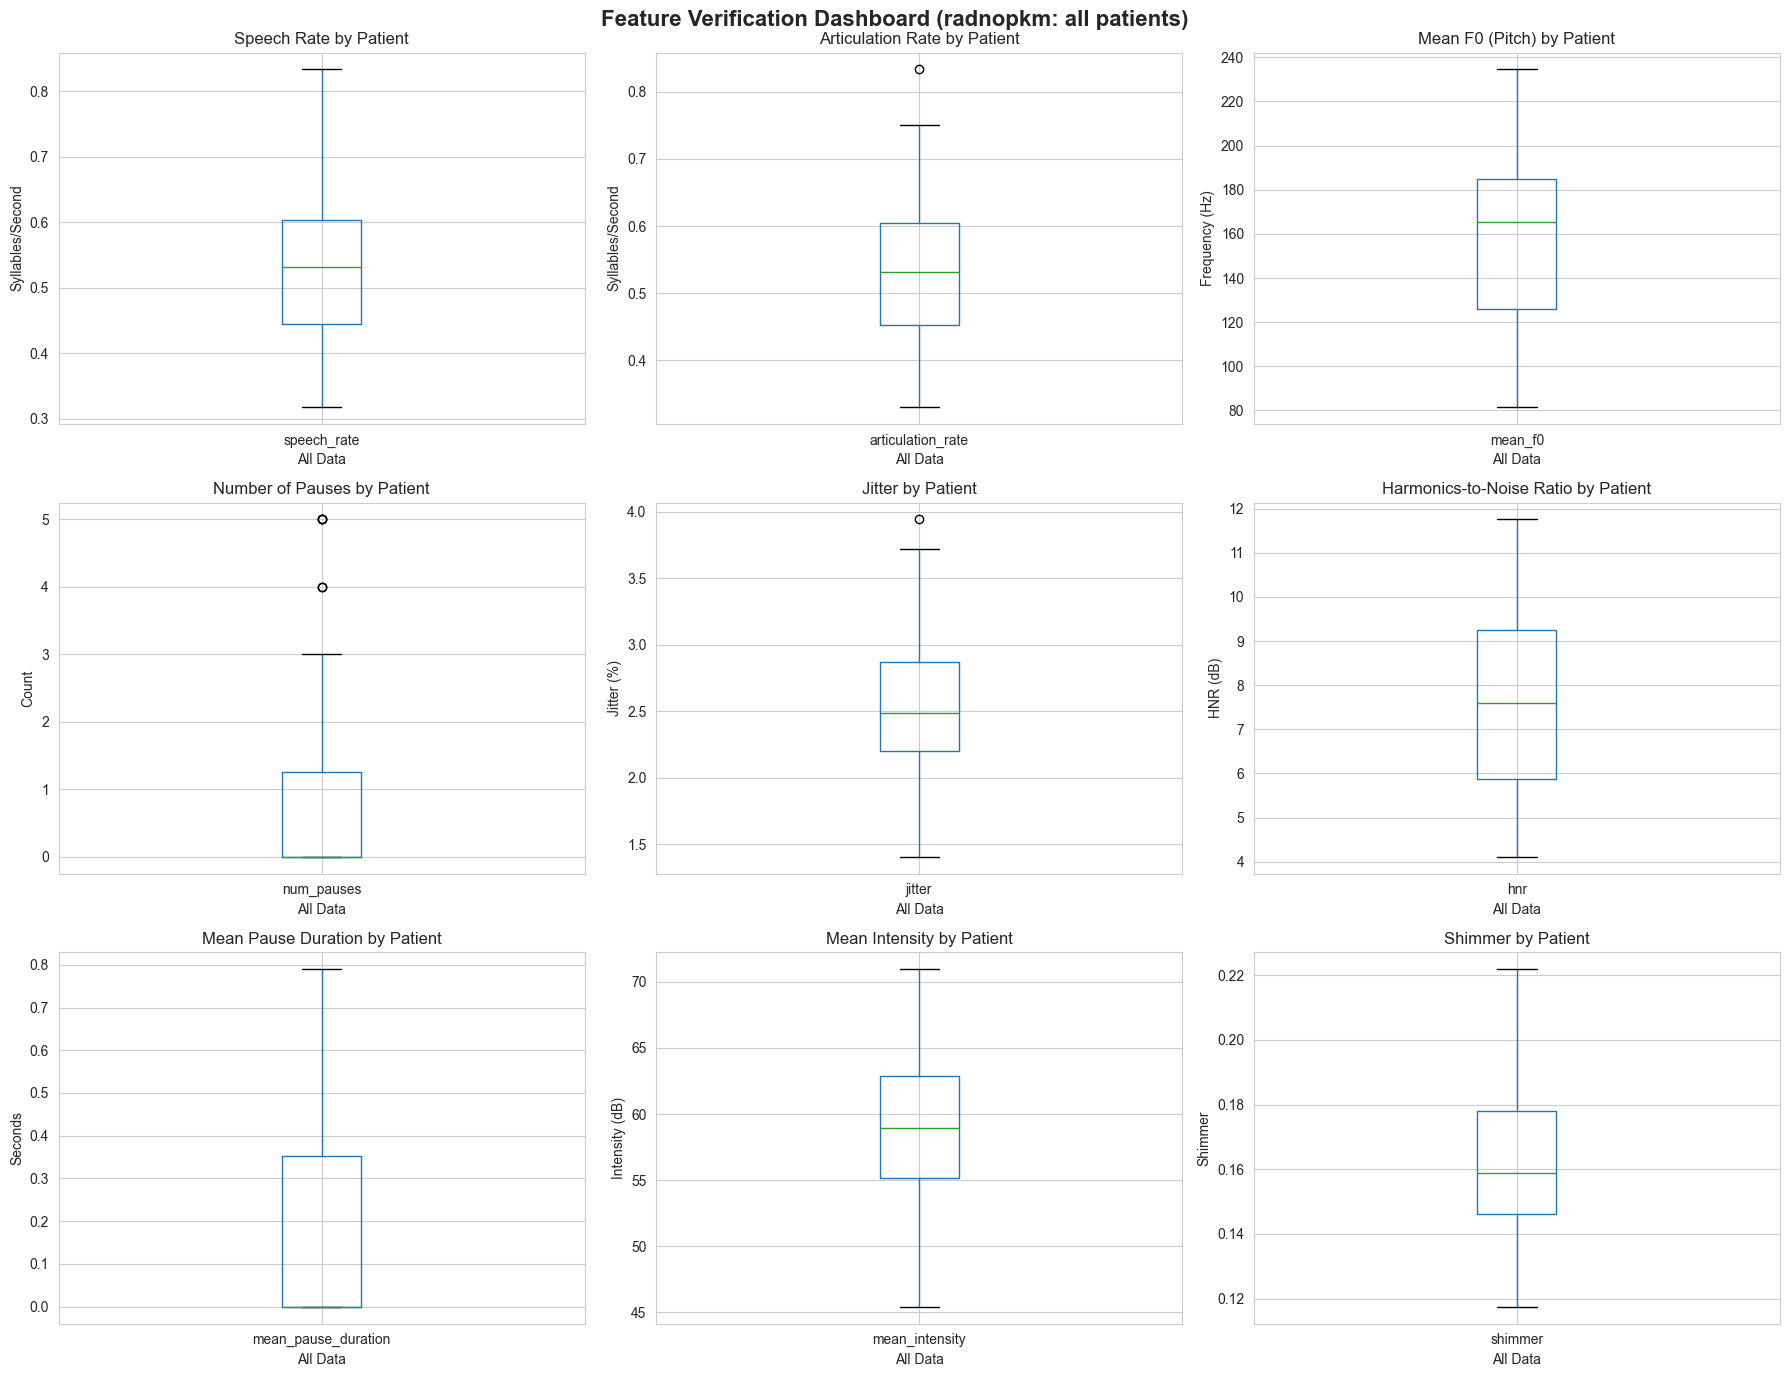


VERIFICATION DASHBOARD CREATED (radnopkm: all patients)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Use all patients in the group 'radnopkm' if present, otherwise all data
if 'patient' in features_df.columns and 'group' in features_df.columns:
    features_df['patient'] = pd.to_numeric(features_df['patient'], errors='coerce')
    plot_df = features_df[features_df['group'] == 'radnopkm']
    print('Included patients:', sorted(plot_df['patient'].unique()))
else:
    print("Warning: 'patient' or 'group' column not found. Plotting all data.")
    plot_df = features_df

# Create comprehensive verification plots
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Feature Verification Dashboard (radnopkm: all patients)', fontsize=16, fontweight='bold')

# 1. Speech Rate Comparison
ax = axes[0, 0]
if 'patient' in plot_df.columns:
    plot_df.boxplot(column='speech_rate', by='patient', ax=ax)
    ax.set_xlabel('Patient')
else:
    plot_df.boxplot(column='speech_rate', ax=ax)
    ax.set_xlabel('All Data')
ax.set_title('Speech Rate by Patient')
ax.set_ylabel('Syllables/Second')
plt.sca(ax)
plt.xticks(rotation=0)

# 2. Articulation Rate Comparison
ax = axes[0, 1]
if 'patient' in plot_df.columns:
    plot_df.boxplot(column='articulation_rate', by='patient', ax=ax)
    ax.set_xlabel('Patient')
else:
    plot_df.boxplot(column='articulation_rate', ax=ax)
    ax.set_xlabel('All Data')
ax.set_title('Articulation Rate by Patient')
ax.set_ylabel('Syllables/Second')
plt.sca(ax)
plt.xticks(rotation=0)

# 3. Pitch (F0) Comparison
ax = axes[0, 2]
if 'patient' in plot_df.columns:
    plot_df.boxplot(column='mean_f0', by='patient', ax=ax)
    ax.set_xlabel('Patient')
else:
    plot_df.boxplot(column='mean_f0', ax=ax)
    ax.set_xlabel('All Data')
ax.set_title('Mean F0 (Pitch) by Patient')
ax.set_ylabel('Frequency (Hz)')
plt.sca(ax)
plt.xticks(rotation=0)

# 4. Pause Analysis
ax = axes[1, 0]
if 'patient' in plot_df.columns:
    plot_df.boxplot(column='num_pauses', by='patient', ax=ax)
    ax.set_xlabel('Patient')
else:
    plot_df.boxplot(column='num_pauses', ax=ax)
    ax.set_xlabel('All Data')
ax.set_title('Number of Pauses by Patient')
ax.set_ylabel('Count')
plt.sca(ax)
plt.xticks(rotation=0)

# 5. Jitter Comparison
ax = axes[1, 1]
if 'patient' in plot_df.columns:
    plot_df.boxplot(column='jitter', by='patient', ax=ax)
    ax.set_xlabel('Patient')
else:
    plot_df.boxplot(column='jitter', ax=ax)
    ax.set_xlabel('All Data')
ax.set_title('Jitter by Patient')
ax.set_ylabel('Jitter (%)')
plt.sca(ax)
plt.xticks(rotation=0)

# 6. HNR Comparison
ax = axes[1, 2]
if 'patient' in plot_df.columns:
    plot_df.boxplot(column='hnr', by='patient', ax=ax)
    ax.set_xlabel('Patient')
else:
    plot_df.boxplot(column='hnr', ax=ax)
    ax.set_xlabel('All Data')
ax.set_title('Harmonics-to-Noise Ratio by Patient')
ax.set_ylabel('HNR (dB)')
plt.sca(ax)
plt.xticks(rotation=0)

# 7. Mean Pause Duration
ax = axes[2, 0]
if 'patient' in plot_df.columns:
    plot_df.boxplot(column='mean_pause_duration', by='patient', ax=ax)
    ax.set_xlabel('Patient')
else:
    plot_df.boxplot(column='mean_pause_duration', ax=ax)
    ax.set_xlabel('All Data')
ax.set_title('Mean Pause Duration by Patient')
ax.set_ylabel('Seconds')
plt.sca(ax)
plt.xticks(rotation=0)

# 8. Intensity Comparison
ax = axes[2, 1]
if 'patient' in plot_df.columns:
    plot_df.boxplot(column='mean_intensity', by='patient', ax=ax)
    ax.set_xlabel('Patient')
else:
    plot_df.boxplot(column='mean_intensity', ax=ax)
    ax.set_xlabel('All Data')
ax.set_title('Mean Intensity by Patient')
ax.set_ylabel('Intensity (dB)')
plt.sca(ax)
plt.xticks(rotation=0)

# 9. Shimmer Comparison
ax = axes[2, 2]
if 'patient' in plot_df.columns:
    plot_df.boxplot(column='shimmer', by='patient', ax=ax)
    ax.set_xlabel('Patient')
else:
    plot_df.boxplot(column='shimmer', ax=ax)
    ax.set_xlabel('All Data')
ax.set_title('Shimmer by Patient')
ax.set_ylabel('Shimmer')
plt.sca(ax)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("VERIFICATION DASHBOARD CREATED (All patients)")
print("="*80)

In [30]:
def visualize_audio_features(audio_file):
    """
    Visualize extracted features for a single audio file to verify extraction.
    Helps manually check if syllable detection and pause detection are accurate.
    """
    import matplotlib.pyplot as plt
    from scipy.signal import find_peaks
    from scipy.ndimage import gaussian_filter1d
    
    # Load audio
    y, sr = librosa.load(audio_file, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    
    # Create figure
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    fig.suptitle(f'Feature Extraction Verification: {os.path.basename(audio_file)}', 
                 fontsize=14, fontweight='bold')
    
    # Time array
    time = np.linspace(0, duration, len(y))
    
    # 1. Waveform with detected syllables
    ax = axes[0]
    ax.plot(time, y, alpha=0.6, linewidth=0.5)
    ax.set_title('Waveform with Syllable Detection')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    
    # Overlay syllable detection (matches improved algorithm)
    hop_length = 512
    rms = librosa.feature.rms(y=y, hop_length=hop_length)[0]
    rms_norm = rms / (np.max(rms) + 1e-10)
    
    # Use combined energy + spectral like in the function
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)[0]
    spectral_norm = spectral_centroid / (np.max(spectral_centroid) + 1e-10)
    combined = (0.7 * rms_norm + 0.3 * spectral_norm)
    energy_smooth = gaussian_filter1d(combined, sigma=3)  # UPDATED: Less smoothing
    
    threshold = np.mean(energy_smooth) + 0.02 * np.std(energy_smooth)  # UPDATED: More sensitive
    threshold = max(threshold, 0.03)
    
    min_distance = int(sr / hop_length * 0.065)  # UPDATED: 65ms for Arabic
    energy_peaks, _ = find_peaks(energy_smooth, height=threshold, 
                                   distance=min_distance, prominence=0.01, width=1)
    
    times_rms = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_length)
    syllable_times = times_rms[energy_peaks]
    
    for t in syllable_times:
        ax.axvline(x=t, color='red', alpha=0.5, linestyle='--', linewidth=1)
    ax.text(0.02, 0.95, f'Detected Syllables: {len(energy_peaks)}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 2. Energy envelope with threshold
    ax = axes[1]
    ax.plot(times_rms, energy_smooth, label='Smoothed Energy', linewidth=2)
    ax.axhline(y=threshold, color='green', linestyle='--', label='Syllable Threshold', linewidth=1.5)
    ax.scatter(syllable_times, energy_smooth[energy_peaks], color='red', 
               s=100, zorder=5, label='Detected Peaks', marker='o')
    ax.set_title('Energy Envelope and Syllable Peaks')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized Energy')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # 3. Pause detection visualization
    ax = axes[2]
    rms_db = librosa.amplitude_to_db(rms, ref=np.max)
    
    # Calculate adaptive threshold
    noise_floor = np.percentile(rms_db, 20)
    dynamic_range = np.max(rms_db) - noise_floor
    silence_threshold = noise_floor + 0.15 * dynamic_range
    
    ax.plot(times_rms, rms_db, label='Energy (dB)', linewidth=2)
    ax.axhline(y=silence_threshold, color='orange', linestyle='--', 
               label='Pause Threshold (Adaptive)', linewidth=1.5)
    ax.fill_between(times_rms, -80, silence_threshold, 
                     where=(rms_db < silence_threshold), 
                     color='yellow', alpha=0.3, label='Detected Pauses')
    ax.set_title('Pause Detection')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Energy (dB)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # 4. Pitch contour
    ax = axes[3]
    snd = parselmouth.Sound(audio_file)
    pitch = call(snd, "To Pitch", 0.0, 40, 500)
    
    # Extract pitch values
    pitch_values = pitch.selected_array['frequency']
    pitch_times = pitch.xs()
    
    # Filter out unvoiced frames (0 Hz)
    voiced_mask = pitch_values > 0
    voiced_times = pitch_times[voiced_mask]
    voiced_pitch = pitch_values[voiced_mask]
    
    if len(voiced_pitch) > 0:
        ax.plot(voiced_times, voiced_pitch, 'b-', linewidth=1.5, label='F0 Contour')
        mean_f0 = np.mean(voiced_pitch)
        ax.axhline(y=mean_f0, color='red', linestyle='--', 
                   label=f'Mean F0: {mean_f0:.1f} Hz', linewidth=1.5)
        ax.fill_between(voiced_times, 40, 500, where=(voiced_pitch > 0), 
                        alpha=0.1, color='blue')
        ax.set_ylim([40, 500])
    
    ax.set_title('Pitch (F0) Contour')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    output_name = f"verification_{os.path.basename(audio_file).replace('.wav', '.png')}"
    plt.show()
    
    return output_name

# Example: Visualize a file for verification
print("\n" + "="*80)
print("GENERATING INDIVIDUAL FILE VERIFICATION PLOTS")
print("="*80)
print("\nGenerating verification plots for sample files...")
print("(You can run this function on any file to verify extraction accuracy)\n")

# Example usage (update the path to a real file if needed):
# visualize_audio_features('pipelined recordings/your_file.wav')
print("\n✓ To verify other files, call: visualize_audio_features('path/to/file.wav')")



GENERATING INDIVIDUAL FILE VERIFICATION PLOTS

Generating verification plots for sample files...
(You can run this function on any file to verify extraction accuracy)


✓ To verify other files, call: visualize_audio_features('path/to/file.wav')


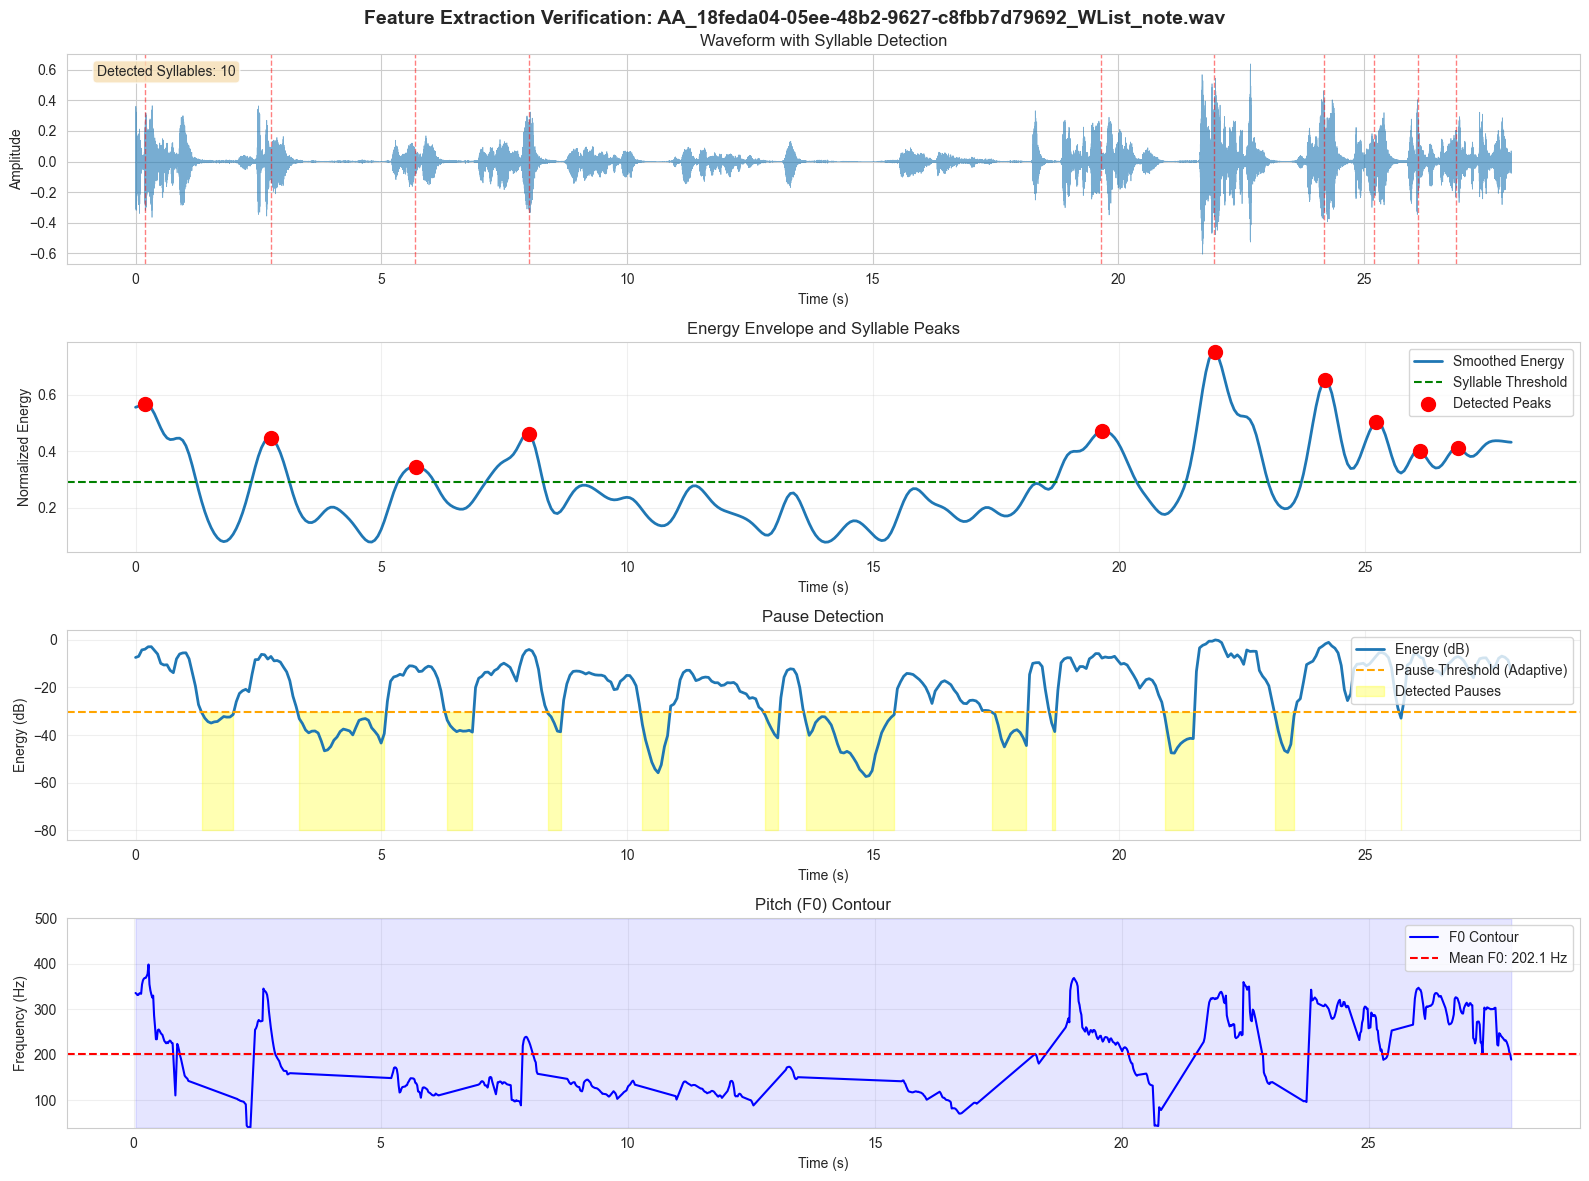

'verification_AA_18feda04-05ee-48b2-9627-c8fbb7d79692_WList_note.png'

In [31]:
visualize_audio_features('pipelined recordings/AA_18feda04-05ee-48b2-9627-c8fbb7d79692_WList_note.wav')


## Feature Definitions Reference

**Temporal Features:**
- **Speech Rate**: Syllables per second (including pauses)
- **Articulation Rate**: Syllables per second (excluding pauses >200ms)
- **Total Speaking Time**: Duration of actual speech (seconds)
- **Total Pause Time**: Sum of silent intervals >200ms (seconds)
- **Number of Pauses**: Count of pauses >200ms
- **Mean Pause Duration**: Average pause length (seconds)

**Prosodic Features:**
- **Mean F0**: Average fundamental frequency (Hz)
- **Pitch Variability (Stdev F0)**: Standard deviation of F0 (Hz)
- **Mean Intensity**: Average signal intensity (dB)
- **Intensity Variability**: Standard deviation of intensity (dB)
- **Jitter**: Cycle-to-cycle F0 variation (%)
- **Shimmer**: Cycle-to-cycle amplitude variation
- **HNR**: Harmonics-to-Noise Ratio (dB)

**Spectral Features:**
- **MFCCs 1-13**: Mel-Frequency Cepstral Coefficients (mean and std for each)

## Spectrogram Analysis

Visualize the frequency content over time to see syllable patterns, formants, and voice characteristics.

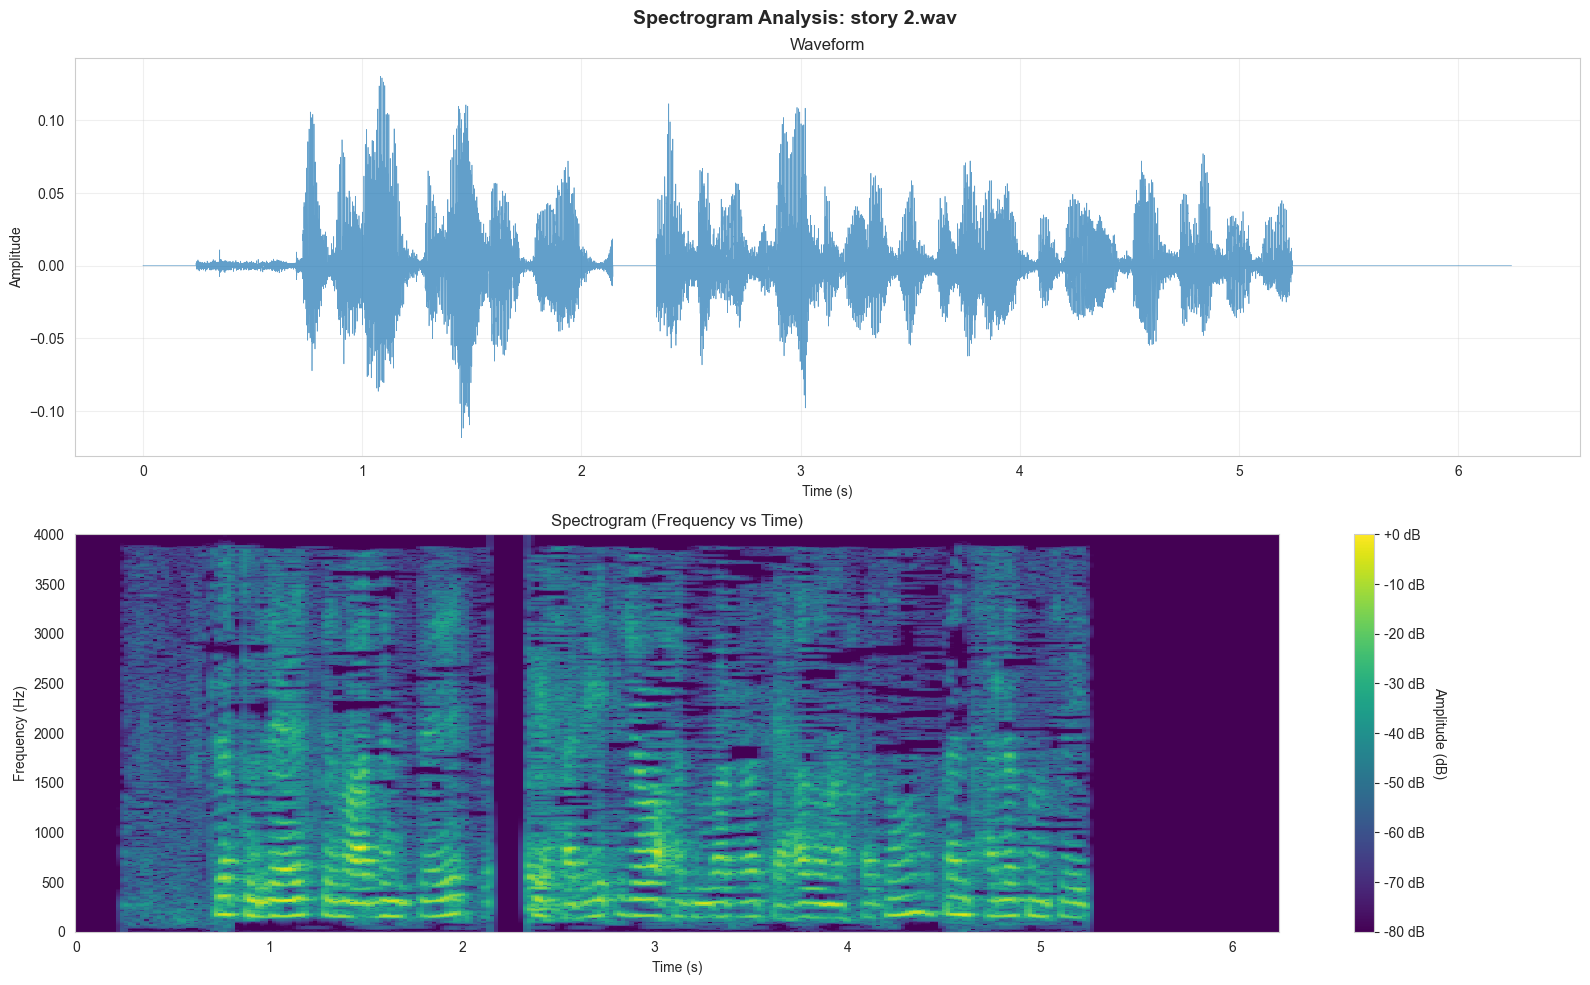


✅ Spectrogram shows:
   - Bright horizontal bands = Formants (vowel characteristics)
   - Vertical striations = Individual syllables/pitch periods
   - Dark gaps = Pauses or consonants
   - Energy concentration below 500 Hz = Fundamental frequency (F0)


In [ ]:
# Load and visualize spectrogram for Patient 2 - Story 2
audio_file = 'pipelined recordings/AA_18feda04-05ee-48b2-9627-c8fbb7d79692_WList_note.wav'
y, sr = librosa.load(audio_file, sr=None)
duration = librosa.get_duration(y=y, sr=sr)

# Create figure with spectrogram
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle(f'Spectrogram Analysis: {os.path.basename(audio_file)}', fontsize=14, fontweight='bold')

# 1. Waveform
ax = axes[0]
time = np.linspace(0, duration, len(y))
ax.plot(time, y, alpha=0.7, linewidth=0.5)
ax.set_title('Waveform')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.grid(True, alpha=0.3)

# 2. Spectrogram (mel-scaled for better frequency resolution in speech range)
ax = axes[1]
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='hz', x_axis='time', sr=sr, ax=ax, cmap='viridis')
ax.set_title('Spectrogram (Frequency vs Time)')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')
ax.set_ylim([0, 4000])  # Focus on speech range (0-4kHz)

# Add colorbar
cbar = fig.colorbar(img, ax=ax, format='%+2.0f dB')
cbar.set_label('Amplitude (dB)', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

print("\n✅ Spectrogram shows:")
print("   - Bright horizontal bands = Formants (vowel characteristics)")
print("   - Vertical striations = Individual syllables/pitch periods")
print("   - Dark gaps = Pauses or consonants")
print("   - Energy concentration below 500 Hz = Fundamental frequency (F0)")